## Simulation d'un processus de Hawkes par thinning

In [5]:
import numpy as np
from scipy.stats import kstest
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

mu=1
alpha=0.5
beta=2
Tmax=100

def simu_hawkes(mu,alpha,beta,Tmax):
    t=0
    events=[]
    lambda_t=mu
    while t<Tmax:
        lambda_sup=lambda_t
        incr=np.random.exponential(1/lambda_sup)
        t_cand=t+incr
        U=np.random.uniform(0,1)
        lambda_cand=lambda_t*np.exp(-beta*incr)+mu*(1-np.exp(-beta*incr))
        if U < lambda_cand/lambda_sup:
            events.append(t_cand)
            lambda_t=lambda_cand+alpha*beta
        else:
            lambda_t=lambda_cand
        t=t_cand
    return(events)




In [6]:
events=simu_hawkes(mu,alpha,beta,Tmax)


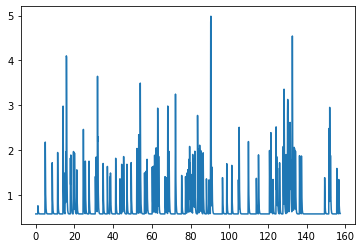

In [22]:
events=simu_hawkes(mu,alpha,beta,Tmax)
np.size(events)

def intensity(events,mu,alpha,beta,Tmax,t):
    events_arr=np.array(events)
    if events_arr.any()<t:
        events_t=events_arr[events_arr<t]
        lambda_t=mu+np.sum(alpha*beta*np.exp(-beta*(t-events_t)))
    else:
        lambda_t=mu 
    return(lambda_t)


x = np.arange(0, Tmax,step=0.1)
intensity_list=[]
for i in x:
    intensity_list.append(intensity(events,mu,alpha,beta,Tmax,i))


intensity_vec=np.array(intensity_list)
plt.plot(x,intensity_vec)
plt.show()

## Compensateur

In [23]:
def compensateur(events,mu,alpha,beta,t):
    events_arr=np.array(events)
    events_t=events_arr[events_arr<t]
    comp=mu*t+alpha*np.sum(1-np.exp(-beta*(t-events_t)))
    return(comp)

##  Test d'ajustement

In [24]:
compensateur(events,mu,alpha,beta,10)

6.667693702529864

In [25]:
events_transformed=[]

for i in range(np.size(events)):
    events_arr=np.array(events)
    t=events_arr[i]
    events_t=events_arr[events_arr<t]
    t_trans=compensateur(events_t,mu,alpha,beta,t)
    events_transformed.append(t_trans)
    
diff_events=np.diff(events_transformed)

In [26]:
kstest(diff_events, cdf="expon")

KstestResult(statistic=0.11373758857089022, pvalue=0.03611199556535427, statistic_location=0.9082946043285602, statistic_sign=1)

## Vraisemblance

In [27]:
def log_likelihood(theta,events_list):
    mu, alpha, beta = theta
    if mu <= 0 or beta <= 0:
        return 1e5
    n=np.size(events_list)
    intensity=np.log(mu)-events_list[1]
    lambda_t=mu+alpha*beta
    lambda_t_moins=mu
    
    for k in range(2,len(events_list)):
        lambda_t_moins=mu+(lambda_t-mu)*np.exp(-beta*(events_list[k]-events_list[k-1]))
        lambda_t = lambda_t_moins + alpha*beta
        if lambda_t_moins <= 0:
                return 1e5
        intensity += np.log(lambda_t_moins)
    
    likelihood=intensity-compensateur(events_list,mu,alpha,beta,events_list[-1])   
    return(-likelihood)


  

## Maximum de vraisemblance

In [28]:
events_list=events

In [29]:
epsilon=1e-5
bounds=((epsilon, None), (epsilon, 1-epsilon), (epsilon, None))
init=np.array((1,0,1))


In [30]:
minimize(fun=log_likelihood, x0=init, args=events_list,method="L-BFGS-B")

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 136.58206965566495
        x: [ 7.345e-01  2.392e-01  1.432e+01]
      nit: 21
      jac: [ 1.961e-04  1.620e-04  2.842e-06]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

## Données Twitter

In [31]:

if __name__ == "__main__":

    table = pd.read_csv("clust-qt08080902w3mfq5.txt", skiprows=4, sep="	",
                        names=['a', 'b', 'c', 'd', 'e', 'f'])
    index = table.index
    condition = table["a"].notnull()
    index = index[condition]

    print("s")


    #indexToExtract = 2591293
    indexToExtract = 137082
    #indexToExtract = 36543

    indexInTable = 0
    flag = int(table.iloc[index[indexInTable]]["d"]) == indexToExtract

    while not (flag):
        indexInTable += 1
        flag = int(table.iloc[index[indexInTable]]["d"]) == indexToExtract

    #indexInTable = 8500
    extractedMeme = table.iloc[index[indexInTable]: index[indexInTable + 1]]

    ### Print phrases

    print(extractedMeme.shape)
    for i in range(extractedMeme.shape[0]):
        try:
            int(extractedMeme.iloc[i]["d"])
            pass
        except:
            print(extractedMeme.iloc[i]["d"])

    ### Convert to times

    timesList = []

    for i in range(extractedMeme.shape[0]):
        try:
            timesList += [datetime.strptime(extractedMeme.iloc[i]["c"], "%Y-%m-%d %H:%M:%S").timestamp()]
        except:
            pass

    # timesList = np.unique(np.sort(np.array(timesList) - timesList[0])/100000)
    timesList = np.sort(np.array(timesList) - timesList[0])/100000




s
(124, 6)
workers of the world unite
workers of the world unite you have nothing to lose but your chains
workers of the world
you have nothing to lose
nothing to lose but their chains


### Estimation des paramètres par maximum de vraisemblance

In [32]:

init=np.array((1,0,1))
estim=minimize(fun=log_likelihood, x0=init, args=timesList,bounds=bounds,method="L-BFGS-B")

In [33]:
estim

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 142.07516185441636
        x: [ 5.774e-01  2.234e-01  6.416e+00]
      nit: 15
      jac: [ 3.723e-04 -8.129e-04 -1.137e-05]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

### Test d'ajustement

In [34]:
events_transformed=[]
mu,alpha,beta=estim.x

for i in range(np.size(timesList)):
    events_arr=np.array(timesList)
    t=events_arr[i]
    events_t=events_arr[events_arr<t]
    t_trans=compensateur(events_t,mu,alpha,beta,t)
    events_transformed.append(t_trans)
    
diff_events=np.diff(events_transformed)

In [35]:
kstest(diff_events, cdf="expon")

KstestResult(statistic=0.048682611594303316, pvalue=0.9315827502069995, statistic_location=1.5158438291247123, statistic_sign=1)

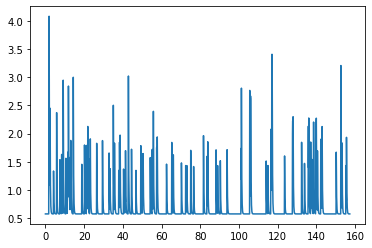

In [36]:
Tmax= timesList[-1]
x = np.arange(0, Tmax,step=0.1)
intensity_list=[]
for i in x:
    intensity_list.append(intensity(timesList,mu,alpha,beta,Tmax,i))


intensity_vec=np.array(intensity_list)
plt.plot(x,intensity_vec)
plt.show()